# Autoencoder: Upsampling Convolutional

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [2]:
transform = transforms.ToTensor()

trainset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=True, transform=transform)
validset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=False, transform=transform)

batch_size = 20

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)

### Model

In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## Encoder ##
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 4, kernel_size=3, stride=1, padding=1)
        
        ## Pooling ##
        self.pool = nn.MaxPool2d(2, 2)
        
        ## Decoder ##
        self.conv3 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)
                
    def forward(self, x):        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv3(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.sigmoid(self.conv4(x))
        
        return x

model = ConvAutoencoder()
print(model)


ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### Loss function and optimizer

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

n_epochs = 20
for iepoch in range(n_epochs):
    batch_loss = 0
    for ibatch, (images, labels) in enumerate(trainloader):
        # Display progress
        progress = ibatch / len(trainloader) * 100
        sys.stdout.write('\rEpoch: {}/{} ... Progress: {:0.2f} % ...'.format(iepoch, n_epochs, progress))
        sys.stdout.flush()
        
        images = images.to(device)
        optimizer.zero_grad()
        output = model(images)        
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item() * images.shape[0]
    epoch_loss = batch_loss / len(trainloader)
    print('Epoch: {} ... Train loss: {:0.6f}'.format(iepoch+1, epoch_loss))

Epoch: 1 ... Train loss: 0.431846
Epoch: 2 ... Train loss: 0.225593
Epoch: 3 ... Train loss: 0.207634
Epoch: 4 ... Train loss: 0.199814
Epoch: 5 ... Train loss: 0.195860
Epoch: 6 ... Train loss: 0.193209
Epoch: 7 ... Train loss: 0.190984
Epoch: 8 ... Train loss: 0.188958
Epoch: 9 ... Train loss: 0.186858
Epoch: 10 ... Train loss: 0.184557
Epoch: 11 ... Train loss: 0.182458
Epoch: 12 ... Train loss: 0.180971
Epoch: 13 ... Train loss: 0.179869
Epoch: 14 ... Train loss: 0.179075
Epoch: 15 ... Train loss: 0.178336
Epoch: 16 ... Train loss: 0.177656
Epoch: 17 ... Train loss: 0.177108
Epoch: 18 ... Train loss: 0.176515
Epoch: 19 ... Train loss: 0.175829
Epoch: 20 ... Train loss: 0.175343


### Visualize the performance

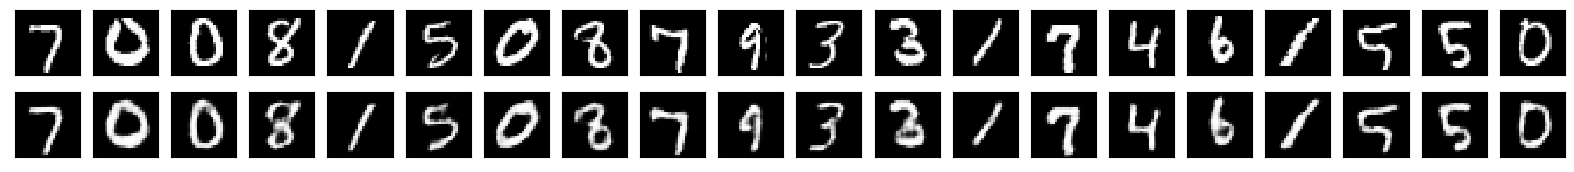

In [9]:
images, labels = next(iter(validloader))
images = images.to(device)
model.eval()
with torch.no_grad():
    output = model(images)
output = output.view(output.shape[0], 1, 28, 28)

images = images.to('cpu').numpy()
output = output.to('cpu').numpy()

fig, ax = plt.subplots(2,images.shape[0], figsize=(images.shape[0],2), dpi=100, sharex=True, sharey=True)
for i in range(output.shape[0]):
    ax[0,i].imshow(images[i,0,:,:], cmap='gray')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    ax[1,i].imshow(output[i,0,:,:], cmap='gray')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
plt.show()